## **TP2 - Gustavo Uñapillco**

#### **Aggregation Frameworks en MongoDB**

Los aggregate se hacen el Shell de MongoDB y las capturas adjuntas son el resultado. 

#### **1. Región y cantidad total de productos vendidos**



``` javascript -- 
db.facturas.aggregate([
  { $unwind: "$item" },
  {
    $group: {
      _id: "$cliente.region",
      totalProductosVendidos: { $sum: "$item.cantidad" }
    }
  }
])

```

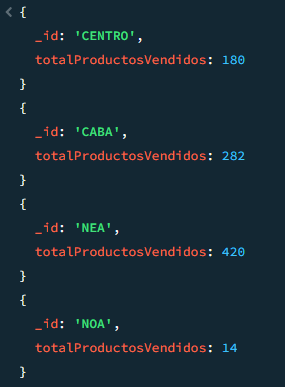

#### **2. Basado en la consulta del punto 1, mostrar sólo la región que tenga el menor ingreso.**



``` javascript -- 
db.facturas.aggregate([
  { $unwind: "$item" },
  {
    $group: {
      _id: "$cliente.region",
      ingreso: { $sum: { $multiply: ["$item.cantidad", "$item.precio"] } }
    }
  },
  { $sort: { ingreso: 1 } },
  { $limit: 1 }
])
```

#### **3. Basado en la consulta del punto 1, mostrar sólo las regiones que tengan una cantidad de productos vendidos superior a 10000.**


``` javascript -- 

db.facturas.aggregate([
  { $unwind: "$item" },
  {
    $group: {
      _id: "$cliente.region",
      productosVendidos: { $sum: "$item.cantidad" },
      totalVentas: {
        $sum: { $multiply: ["$item.cantidad", "$item.precio"] }
      }
    }
  },
  { $match: { productosVendidos: { $gt: 10000 } } },
  { $sort: { productosVendidos: -1 } },
  {
    $project: {
      _id: 0,
      region: "$_id",
      productosVendidos: 1,
      totalVentas: 1
    }
  }
])

```

Para 10000 no me devuelve ningùn valor, pero si ajusto el valor a 300 me devuelve lo siguiente:

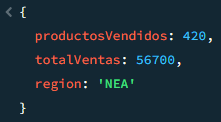

#### **4. Se requiere obtener un reporte que contenga la siguiente información, nro. cuit, apellido y nombre y región y cantidad de facturas, ordenado por apellido.**


``` javascript -- 
db.facturas.aggregate([
  {
    $group: {
      _id: {
        cuit: "$cliente.cuit",
        apellido: "$cliente.apellido",
        nombre: "$cliente.nombre",
        region: "$cliente.region"
      },
      cantidadFacturas: { $sum: 1 }
    }
  },
  {
    $sort: { "_id.apellido": 1 }
  }
])
```

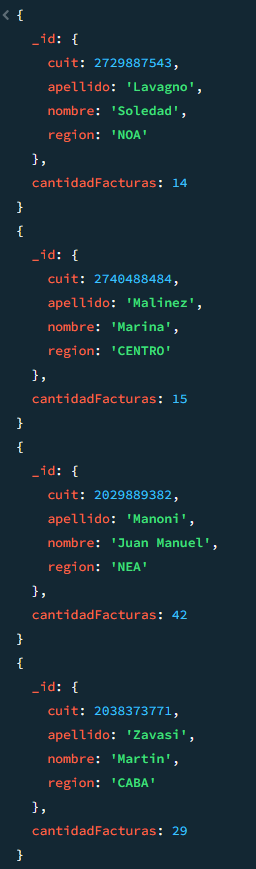

#### **5. Basados en la consulta del punto 4 informar sólo los clientes con número de CUIT mayor a 27000000000.**


``` javascript -- 
db.facturas.aggregate([
  {
    $group: {
      _id: {
        cuit: "$cliente.cuit",
        apellido: "$cliente.apellido",
        nombre: "$cliente.nombre",
        region: "$cliente.region"
      },
      cantidadFacturas: { $sum: 1 }
    }
  },
  { $match: { "_id.cuit": { $gt: NumberLong("27000000000") } } },
  { $sort: { "_id.apellido": 1 } }
])
```

Este aggregate no me devuelve ningùn resultado, si modifico el nùmero a 2700000000 (quitandole un cero):

``` javascript -- 
  { $match: { "_id.cuit": { $gt: NumberLong("2700000000") } } },
```

Obtuve el siguiente resultado: 

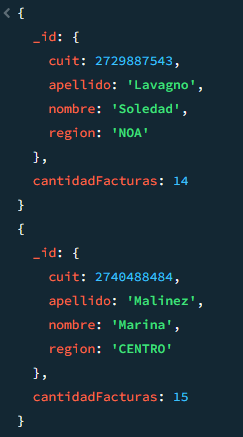

#### **6. Basados en la consulta del punto 5 informar solamente la cantidad de clientes que cumplen con esta condición.**


Con un cero menos
``` javascript -- 
db.facturas.aggregate([
  {
    $group: {
      _id: "$cliente.cuit"
    }
  },
  { $match: { _id: { $gt: NumberLong("2700000000") } } },
  { $count: "cantidadClientes" }
])
```

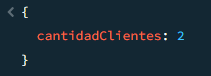

#### **7. Se requiere realizar una consulta que devuelva la siguiente información: producto y cantidad de facturas en las que lo compraron, ordenado por cantidad de facturas descendente.**


``` javascript -- 
db.facturas.aggregate([
  { $unwind: "$item" },
  {
    $group: {
      _id: {
        producto: "$item.producto",
        nroFactura: "$nroFactura"
      }
    }
  },
  {
    $group: {
      _id: "$_id.producto",
      cantidadFacturas: { $sum: 1 }
    }
  },
  { $sort: { cantidadFacturas: -1 } },
  {
    $project: {
      _id: 0,
      producto: "$_id",
      cantidadFacturas: 1
    }
  }
])
```

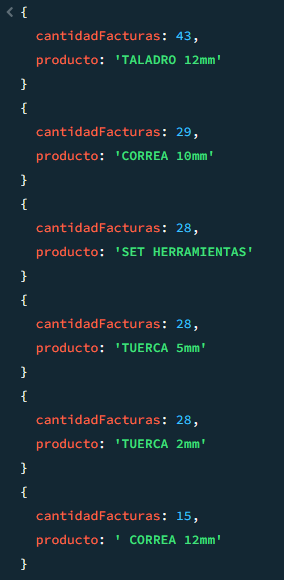

#### **8. Obtener la cantidad total comprada así como también los ingresos totales para cada producto.**


``` javascript -- 
db.facturas.aggregate([
  { $unwind: "$item" },
  {
    $group: {
      _id: "$item.producto",
      cantidadTotal: { $sum: "$item.cantidad" },
      ingresoTotal: {
        $sum: { $multiply: ["$item.cantidad", "$item.precio"] }
      }
    }
  },
  {
    $project: {
      _id: 0,
      producto: "$_id",
      cantidadTotal: 1,
      ingresoTotal: 1
    }
  }
])
```

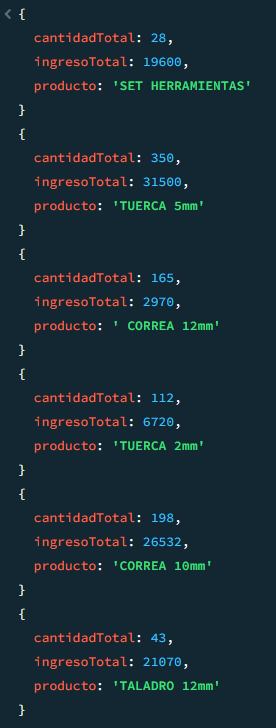

#### **9. Idem el punto anterior, ordenar por ingresos en forma ascendente, saltear el 1ro y mostrar 2do y 3ro.**


``` javascript -- 
db.facturas.aggregate([
  { $unwind: "$item" },
  {
    $group: {
      _id: "$item.producto",
      cantidadTotal: { $sum: "$item.cantidad" },
      ingresoTotal: {
        $sum: { $multiply: ["$item.cantidad", "$item.precio"] }
      }
    }
  },
  { $sort: { ingresoTotal: 1 } },
  { $skip: 1 },
  { $limit: 2 },
  {
    $project: {
      _id: 0,
      producto: "$_id",
      cantidadTotal: 1,
      ingresoTotal: 1
    }
  }
])

```

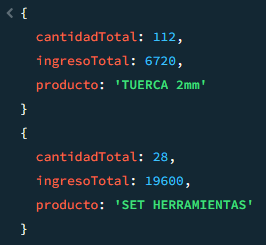

#### **10. Obtener todos productos junto con un array de las personas que lo compraron. En este array deberá haber solo strings con el nombre completo de la persona. Los documentos entregados como resultado deberán tener la siguiente forma: `{producto: “<nombre>”, personas:[“…”, …]`**


``` javascript -- 
db.facturas.aggregate([
  { $unwind: "$item" },
  {
    $group: {
      _id: {
        producto: "$item.producto",
        nombreCompleto: {
          $concat: ["$cliente.nombre", " ", "$cliente.apellido"]
        }
      }
    }
  },
  {
    $group: {
      _id: "$_id.producto",
      personas: { $addToSet: "$_id.nombreCompleto" }
    }
  },
  {
    $project: {
      _id: 0,
      producto: "$_id",
      personas: 1
    }
  }
])
```

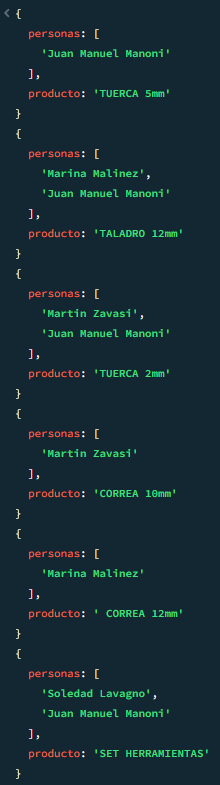

#### **11. Obtener los productos ordenados en forma descendente por la cantidad de diferentes personas que los compraron.**


``` javascript -- 
db.facturas.aggregate([
  { $unwind: "$item" },
  {
    $group: {
      _id: {
        producto: "$item.producto",
        persona: { $concat: ["$cliente.nombre", " ", "$cliente.apellido"] }
      }
    }
  },
  {
    $group: {
      _id: "$_id.producto",
      personasUnicas: { $addToSet: "$_id.persona" }
    }
  },
  {
    $project: {
      _id: 0,
      producto: "$_id",
      cantidadPersonas: { $size: "$personasUnicas" }
    }
  },
  { $sort: { cantidadPersonas: -1 } }
])
```

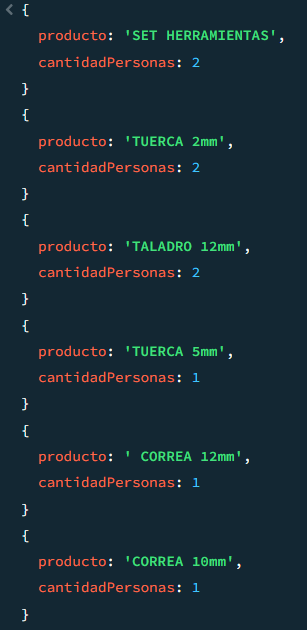

#### **12. Obtener el total gastado por persona y mostrar solo los que gastaron más de 3100000. Los documentos devueltos deben tener el nombre completo del cliente y el total gastado: `{cliente:”<nombreCompleto>”,total:<num>}`**


``` javascript -- 
db.facturas.aggregate([
  { $unwind: "$item" },
  {
    $group: {
      _id: { nombre: "$cliente.nombre", apellido: "$cliente.apellido" },
      totalGastado: {
        $sum: { $multiply: ["$item.cantidad", "$item.precio"] }
      }
    }
  },
  {
    $project: {
      _id: 0,
      cliente: {
        $concat: ["$_id.nombre", " ", "$_id.apellido"]
      },
      total: "$totalGastado"
    }
  },
  { $match: { total: { $gt: 3100000 } } }
])

```

Con `{ $match: { total: { $gt: 3100000 } } }` no me devuelve ningùn valor, por lo que decido reducir el valor `{ $match: { total: { $gt: 31000 } } }`

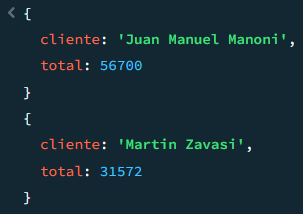

#### **13. Obtener el promedio de gasto por factura por cada región.**


``` javascript -- 
db.facturas.aggregate([
  {
    $project: {
      region: "$cliente.region",
      totalFactura: {
        $sum: {
          $map: {
            input: "$item",
            as: "it",
            in: { $multiply: ["$$it.cantidad", "$$it.precio"] }
          }
        }
      }
    }
  },
  {
    $group: {
      _id: "$region",
      promedioGasto: { $avg: "$totalFactura" }
    }
  },
  {
    $project: {
      _id: 0,
      region: "$_id",
      promedioGasto: 1
    }
  }
])
```

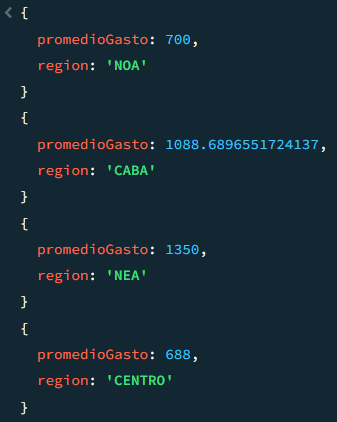

#### **14. Obtener la factura en la que se haya gastado más. En caso de que sean varias obtener la que tenga el número de factura menor.**


``` javascript -- 
db.facturas.aggregate([
  {
    $project: {
      nroFactura: 1,
      totalFactura: {
        $sum: {
          $map: {
            input: "$item",
            as: "it",
            in: { $multiply: ["$$it.cantidad", "$$it.precio"] }
          }
        }
      }
    }
  },
  { $sort: { totalFactura: -1, nroFactura: 1 } },
  { $limit: 1 }
])
```

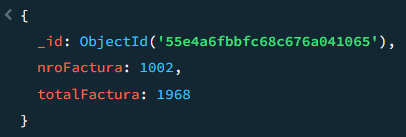

#### **15. Obtener a los clientes indicando cuánto fue lo que más gastó en una única factura.**


``` javascript -- 
db.facturas.aggregate([
  { $unwind: "$item" },
  {
    $group: {
      _id: {
        cuit: "$cliente.cuit",
        nombreCompleto: {
          $concat: ["$cliente.nombre", " ", "$cliente.apellido"]
        },
        nroFactura: "$nroFactura"
      },
      totalFactura: {
        $sum: { $multiply: ["$item.cantidad", "$item.precio"] }
      }
    }
  },
  {
    $group: {
      _id: {
        cuit: "$_id.cuit",
        nombreCompleto: "$_id.nombreCompleto"
      },
      gastoMaximo: { $max: "$totalFactura" }
    }
  },
  {
    $project: {
      _id: 0,
      cliente: "$_id.nombreCompleto",
      gastoMaximo: 1
    }
  }
])
```

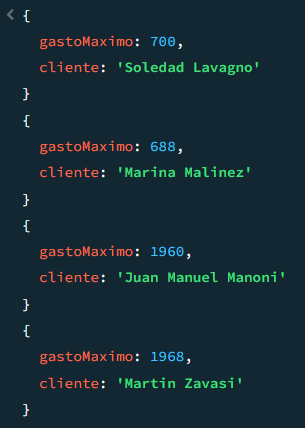

#### **16. Utilizando MapReduce, indicar la cantidad total comprada de cada ítem. Comparar el resultado con el ejercicio 8.**
#### **17. Obtener la información de los clientes que hayan gastado 100000 en una orden junto con el número de orden.**
#### **18. En base a la localidad de los clientes, obtener el total facturado por localidad**